In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20,3)

In [2]:
df = pd.read_csv("./datasetku/data-inflasi-lengkap.csv")
df = df.iloc[:,:-1]
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1969,35.56,25.25,24.51,26.04,19.80,14.42,11.01,11.61,11.61,14.41,-5.15,9.17
1,1970,15.57,13.71,10.24,14.05,14.05,17.65,15.70,12.00,9.60,7.87,10.08,9.16
2,1971,4.26,7.09,7.86,7.97,5.07,2.14,2.14,1.43,2.92,4.38,3.52,2.10
3,1972,1.36,0.66,0.66,2.01,4.14,3.50,2.80,4.23,6.38,9.09,17.69,26.03
4,1973,21.48,19.74,21.05,24.34,25.17,34.46,42.18,41.22,44.00,42.31,30.64,27.17


In [3]:
df_melted = df.melt(id_vars=["Year"], var_name="Month", value_name="Inflasi")
months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
          'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

df_melted['Month'] = df_melted['Month'].map(months)
df_melted['Periode'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'].astype(str) + '-01')

df_melted

,Year,Month,Inflasi,Periode
0,1969,01,35.56,1969-01-01
1,1970,01,15.57,1970-01-01
2,1971,01,4.26,1971-01-01
3,1972,01,1.36,1972-01-01
4,1973,01,21.48,1973-01-01
...,...,...,...,...
667,2020,12,1.59,2020-12-01
668,2021,12,1.87,2021-12-01
669,2022,12,5.51,2022-12-01
670,2023,12,2.61,2023-12-01


In [4]:
df_melted = df_melted[['Periode', 'Inflasi']].sort_values(by='Periode', ascending=False)
df_cleaned = df_melted.dropna(subset=['Inflasi'])
df_cleaned

,Periode,Inflasi
447,2024-08-01,2.12
391,2024-07-01,2.13
335,2024-06-01,2.51
279,2024-05-01,2.84
223,2024-04-01,3.00
...,...,...
224,1969-05-01,19.80
168,1969-04-01,26.04
112,1969-03-01,24.51
56,1969-02-01,25.25


In [5]:
df_new = df_cleaned.reset_index(drop=True)
df_new = df_new.sort_values(by='Periode').set_index('Periode')
df_new = df_new.astype('float32')
pd.set_option('display.precision', 2)

df_new

,Inflasi
Periode,
1969-01-01,35.56
1969-02-01,25.25
1969-03-01,24.51
1969-04-01,26.04
1969-05-01,19.80
...,...
2024-04-01,3.00
2024-05-01,2.84
2024-06-01,2.51


In [6]:
print(df_new.info())
print(df_new.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668 entries, 1969-01-01 to 2024-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Inflasi  668 non-null    float32
dtypes: float32(1)
memory usage: 7.8 KB
None
       Inflasi
count   668.00
mean     10.37
std      10.81
min      -5.15
25%       4.61
50%       7.72
75%      10.93
max      82.42


In [7]:
from itertools import islice

import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.split import split

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
dataset = PandasDataset(df_new, target='Inflasi')
print(dataset)

PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>


In [9]:
#Checking dataset
entry = next(iter(dataset))
print(entry)

{'start': Period('1969-01', 'M'), 'target': array([ 3.556e+01,  2.525e+01,  2.451e+01,  2.604e+01,  1.980e+01,
        1.442e+01,  1.101e+01,  1.161e+01,  1.161e+01,  1.441e+01,
       -5.150e+00,  9.170e+00,  1.557e+01,  1.371e+01,  1.024e+01,
        1.405e+01,  1.405e+01,  1.765e+01,  1.570e+01,  1.200e+01,
        9.600e+00,  7.870e+00,  1.008e+01,  9.160e+00,  4.260e+00,
        7.090e+00,  7.860e+00,  7.970e+00,  5.070e+00,  2.140e+00,
        2.140e+00,  1.430e+00,  2.920e+00,  4.380e+00,  3.520e+00,
        2.100e+00,  1.360e+00,  6.600e-01,  6.600e-01,  2.010e+00,
        4.140e+00,  3.500e+00,  2.800e+00,  4.230e+00,  6.380e+00,
        9.090e+00,  1.769e+01,  2.603e+01,  2.148e+01,  1.974e+01,
        2.105e+01,  2.434e+01,  2.517e+01,  3.446e+01,  4.218e+01,
        4.122e+01,  4.400e+01,  4.231e+01,  3.064e+01,  2.717e+01,
        4.254e+01,  4.670e+01,  4.728e+01,  4.921e+01,  4.921e+01,
        4.322e+01,  3.684e+01,  3.684e+01,  3.519e+01,  3.514e+01,
        3.540e+01,

In [10]:
print(len(entry["target"]))
print(entry["start"])

668
1969-01


In [14]:
print(df_new.iloc[:534])
print(len(df_new.iloc[:534]))
print(df_new.iloc[534:])
print(len(df_new.iloc[534:]))

            Inflasi
Periode            
1969-01-01    35.56
1969-02-01    25.25
1969-03-01    24.51
1969-04-01    26.04
1969-05-01    19.80
...             ...
2013-02-01     4.81
2013-03-01     5.24
2013-04-01     5.07
2013-05-01     5.10
2013-06-01     5.51

[534 rows x 1 columns]
534
            Inflasi
Periode            
2013-07-01     7.94
2013-08-01     7.98
2013-09-01     7.70
2013-10-01     7.72
2013-11-01     7.82
...             ...
2024-04-01     3.00
2024-05-01     2.84
2024-06-01     2.51
2024-07-01     2.13
2024-08-01     2.12

[134 rows x 1 columns]
134


In [15]:
def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)

def plot_dataset_splitting(ori_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(ori_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in ori_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

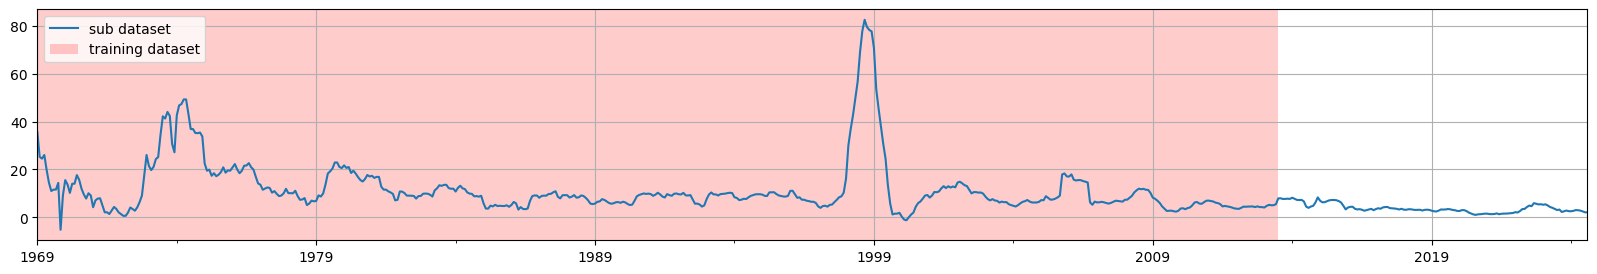

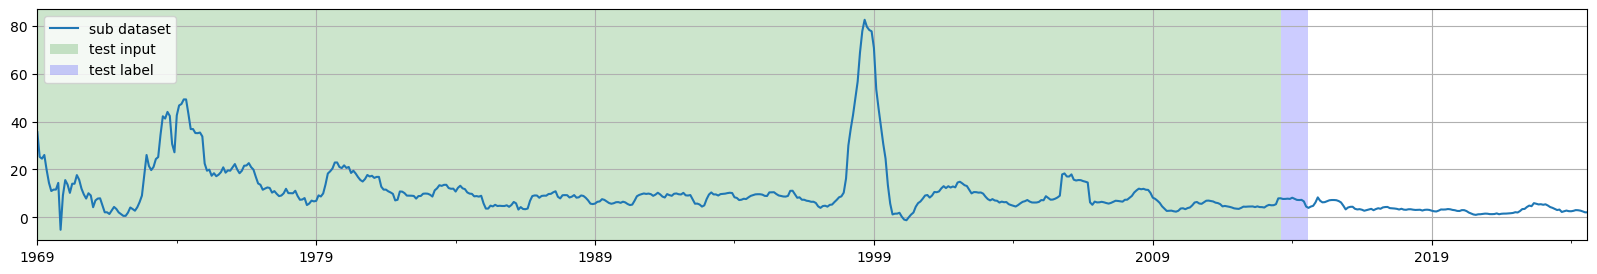

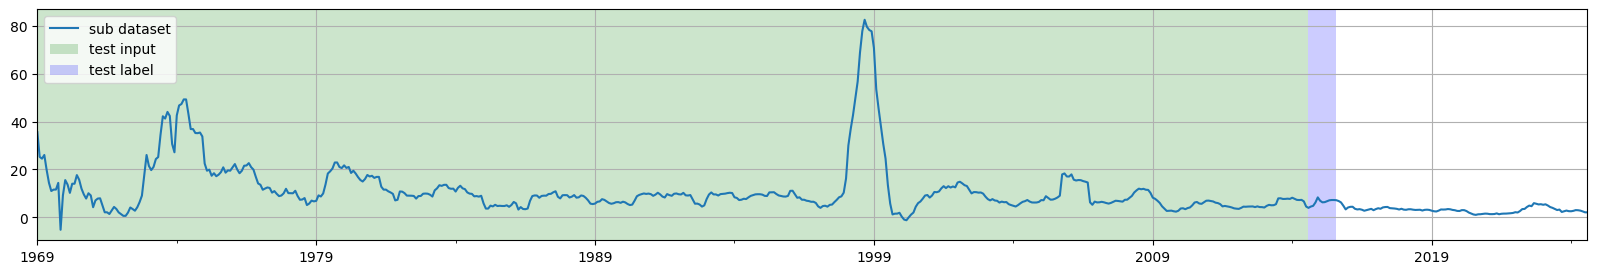

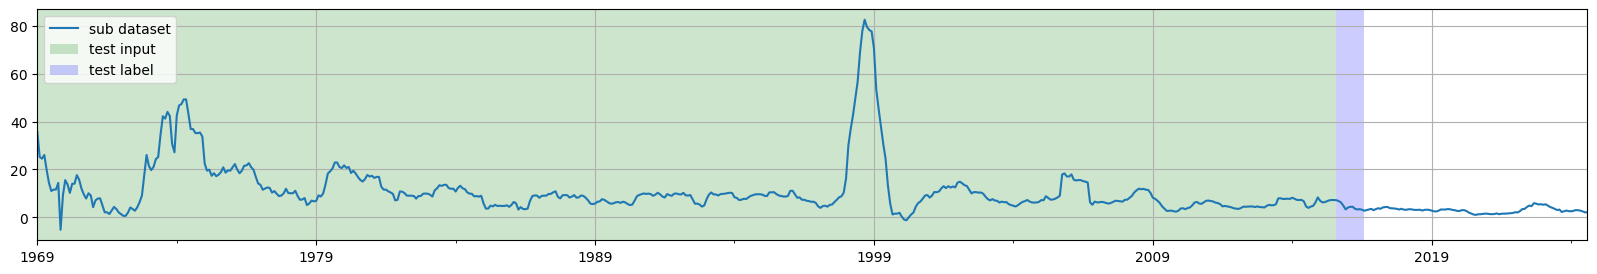

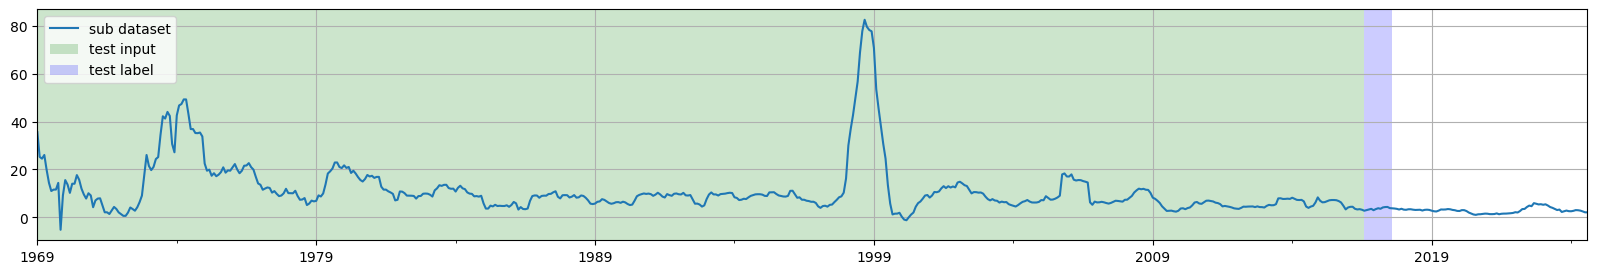

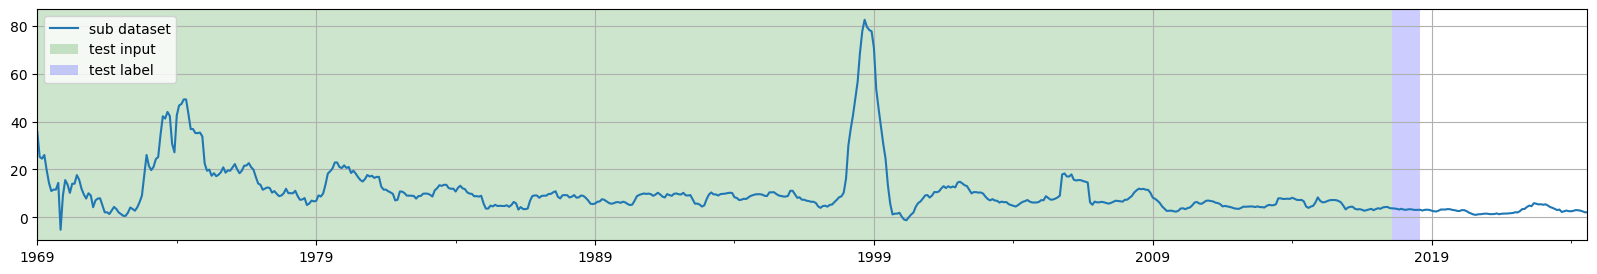

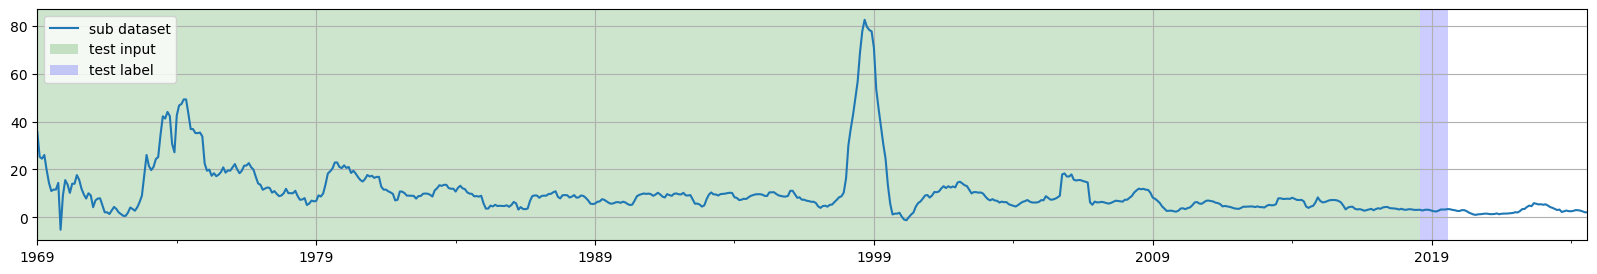

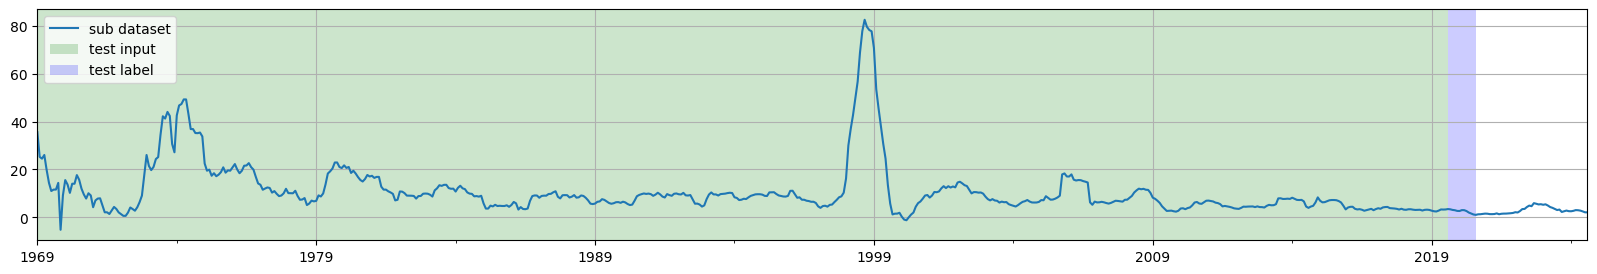

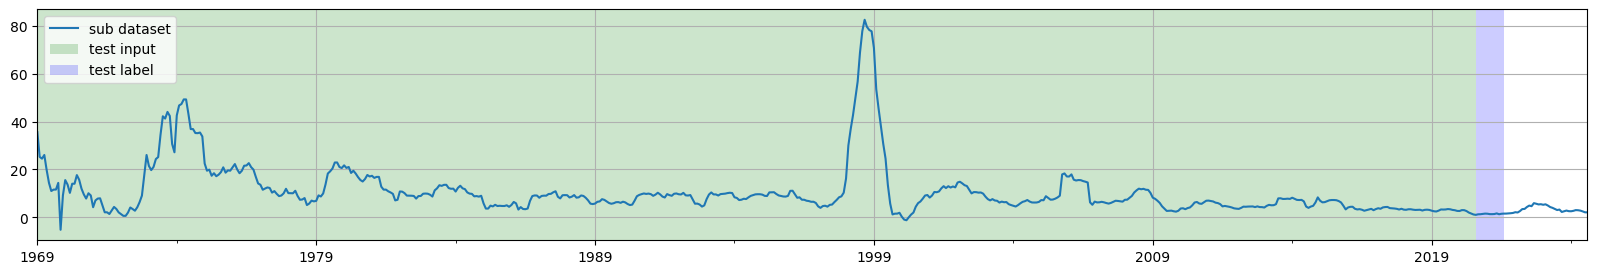

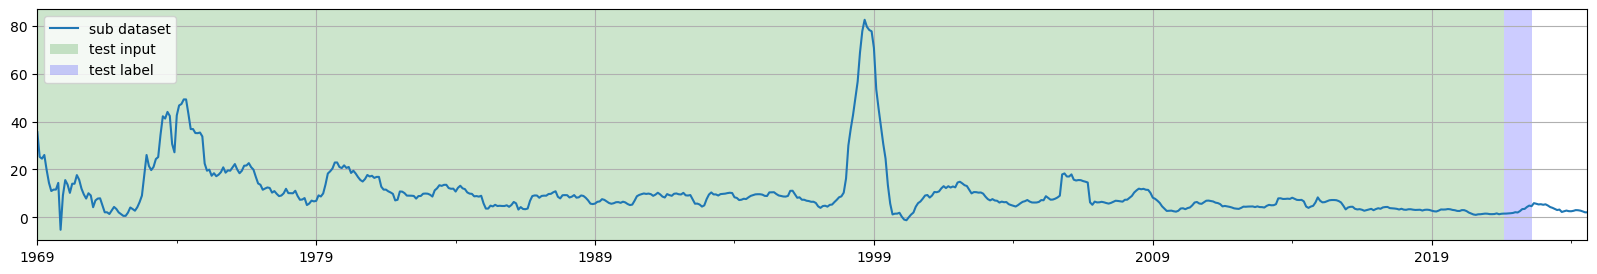

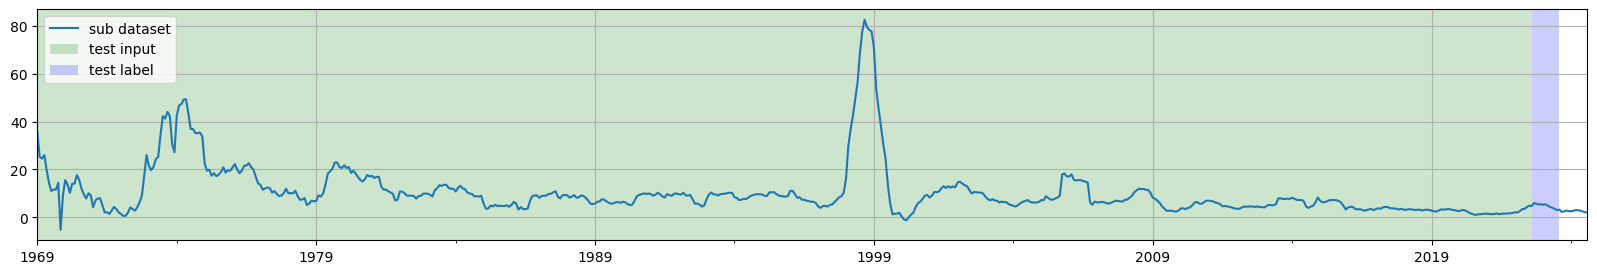

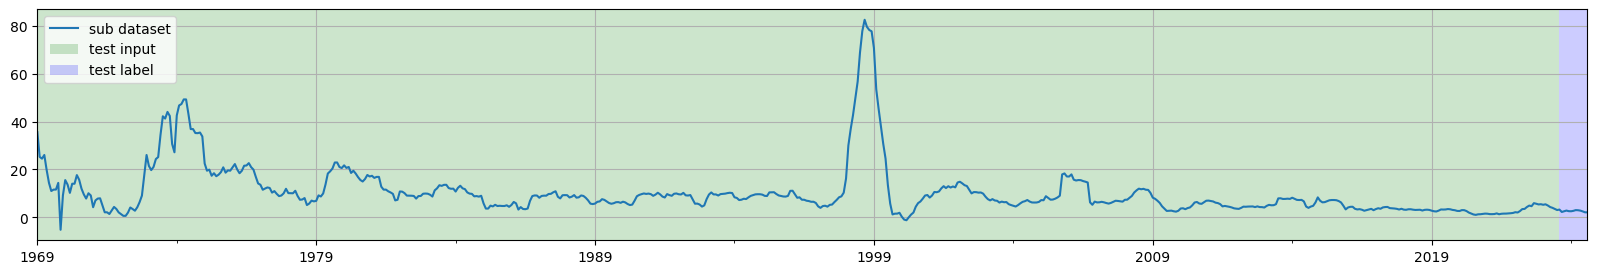

In [19]:
prediction_length = 12
training_dataset, _ = split(dataset, date=pd.Period("2013-06-01", freq="M"))
_, test_template = split(dataset, date=pd.Period("2013-07-01", freq="M"))
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=11,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

In [20]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [21]:
print("TEST INPUT:\n",next(iter(test_pairs.input)))
print("LABEL INPUT:\n",next(iter(test_pairs.label)))

TEST INPUT:
 {'start': Period('1969-01', 'M'), 'target': array([ 3.556e+01,  2.525e+01,  2.451e+01,  2.604e+01,  1.980e+01,
        1.442e+01,  1.101e+01,  1.161e+01,  1.161e+01,  1.441e+01,
       -5.150e+00,  9.170e+00,  1.557e+01,  1.371e+01,  1.024e+01,
        1.405e+01,  1.405e+01,  1.765e+01,  1.570e+01,  1.200e+01,
        9.600e+00,  7.870e+00,  1.008e+01,  9.160e+00,  4.260e+00,
        7.090e+00,  7.860e+00,  7.970e+00,  5.070e+00,  2.140e+00,
        2.140e+00,  1.430e+00,  2.920e+00,  4.380e+00,  3.520e+00,
        2.100e+00,  1.360e+00,  6.600e-01,  6.600e-01,  2.010e+00,
        4.140e+00,  3.500e+00,  2.800e+00,  4.230e+00,  6.380e+00,
        9.090e+00,  1.769e+01,  2.603e+01,  2.148e+01,  1.974e+01,
        2.105e+01,  2.434e+01,  2.517e+01,  3.446e+01,  4.218e+01,
        4.122e+01,  4.400e+01,  4.231e+01,  3.064e+01,  2.717e+01,
        4.254e+01,  4.670e+01,  4.728e+01,  4.921e+01,  4.921e+01,
        4.322e+01,  3.684e+01,  3.684e+01,  3.519e+01,  3.514e+01,
     

In [22]:
backtest_dataset = test_pairs.input
prediction_length = 12
num_samples = 30
device = torch.device("cuda:0")

In [23]:
#Get predictions
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_201029/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

In [24]:
print(len(forecasts))
print(forecasts[2].samples.shape)
# print(next(iter(forecasts)))
print(forecasts[3])
print(tss)

11
(100, 12)
gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[7.5487676, 7.725262 , 7.760217 , ..., 3.4069686, 4.334603 ,
        4.691014 ],
       [7.5468574, 7.6283493, 7.451216 , ..., 7.6400976, 7.207858 ,
        7.4801283],
       [7.721505 , 7.310788 , 7.297737 , ..., 8.123385 , 8.113805 ,
        8.651328 ],
       ...,
       [7.4334297, 6.079674 , 4.9124293, ..., 7.2716417, 6.7561436,
        7.465045 ],
       [6.6167884, 6.547058 , 6.8758764, ..., 5.1026716, 5.2510223,
        3.7609782],
       [7.9631314, 8.07267  , 7.785237 , ..., 7.868246 , 8.383106 ,
        8.937714 ]], dtype=float32), start_date=Period('2015-08', 'M'))
[             0
1969-01  35.56
1969-02  25.25
1969-03  24.51
1969-04  26.04
1969-05  19.80
...        ...
2013-03   5.24
2013-04   5.07
2013-05   5.10
2013-06   5.51
2013-07   7.94

[535 rows x 1 columns],              0
1969-01  35.56
1969-02  25.25
1969-03  24.51
1969-04  26.04
1969-05  19.80
...        ...
2014-03   7.3

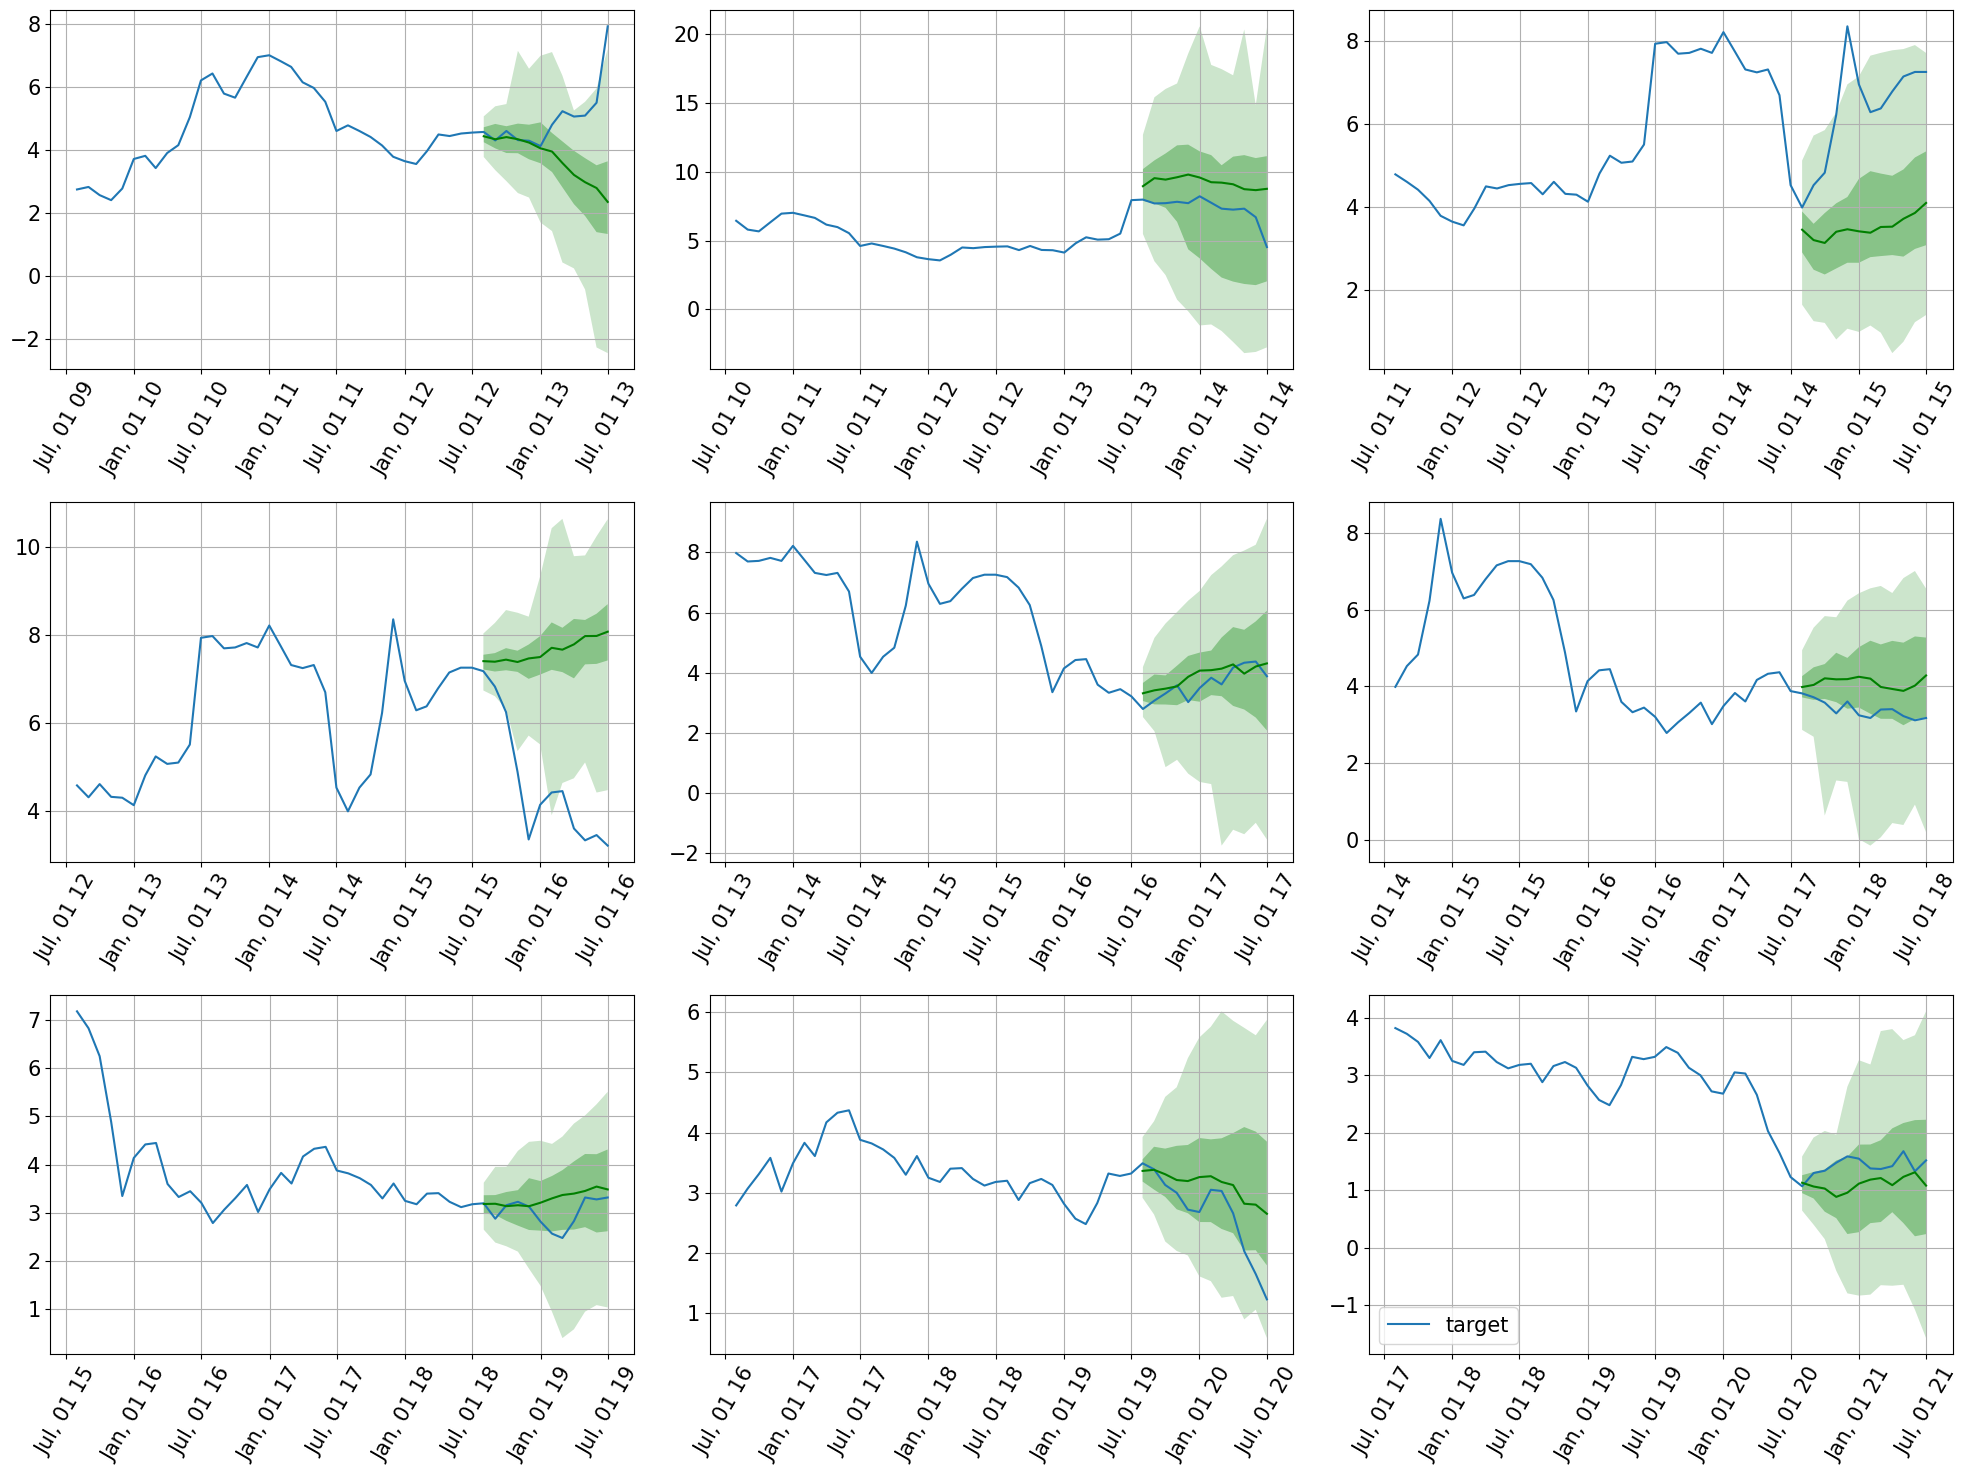

In [25]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [26]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 11it [00:00, 316.39it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [27]:
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])

CRPS: 0.2546327737808554
MSE: 2.938334660999703
MAPE: 0.30535256591710175


In [28]:
#Context Length: 64
forecasts_ctx_len_64, tss_ctx_len_64 = get_lag_llama_predictions(backtest_dataset, prediction_length=12, device=device, \
                                           context_length=64, use_rope_scaling=True, num_samples=30)
forecasts_ctx_len_64 = list(forecasts_ctx_len_64)
tss_ctx_len_64 = list(tss_ctx_len_64)

agg_metrics_ctx_len_64, ts_metrics_ctx_len_64 = evaluator(iter(tss_ctx_len_64), iter(forecasts_ctx_len_64))
print("CRPS:", agg_metrics_ctx_len_64['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64['MSE'])
print('MAPE:', agg_metrics_ctx_len_64['MAPE'])

/tmp/ipykernel_201029/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

Running evaluation: 11it [00:00, 302.14it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.2753042974222709
MSE: 4.556693698194895
MAPE: 0.330360114122882


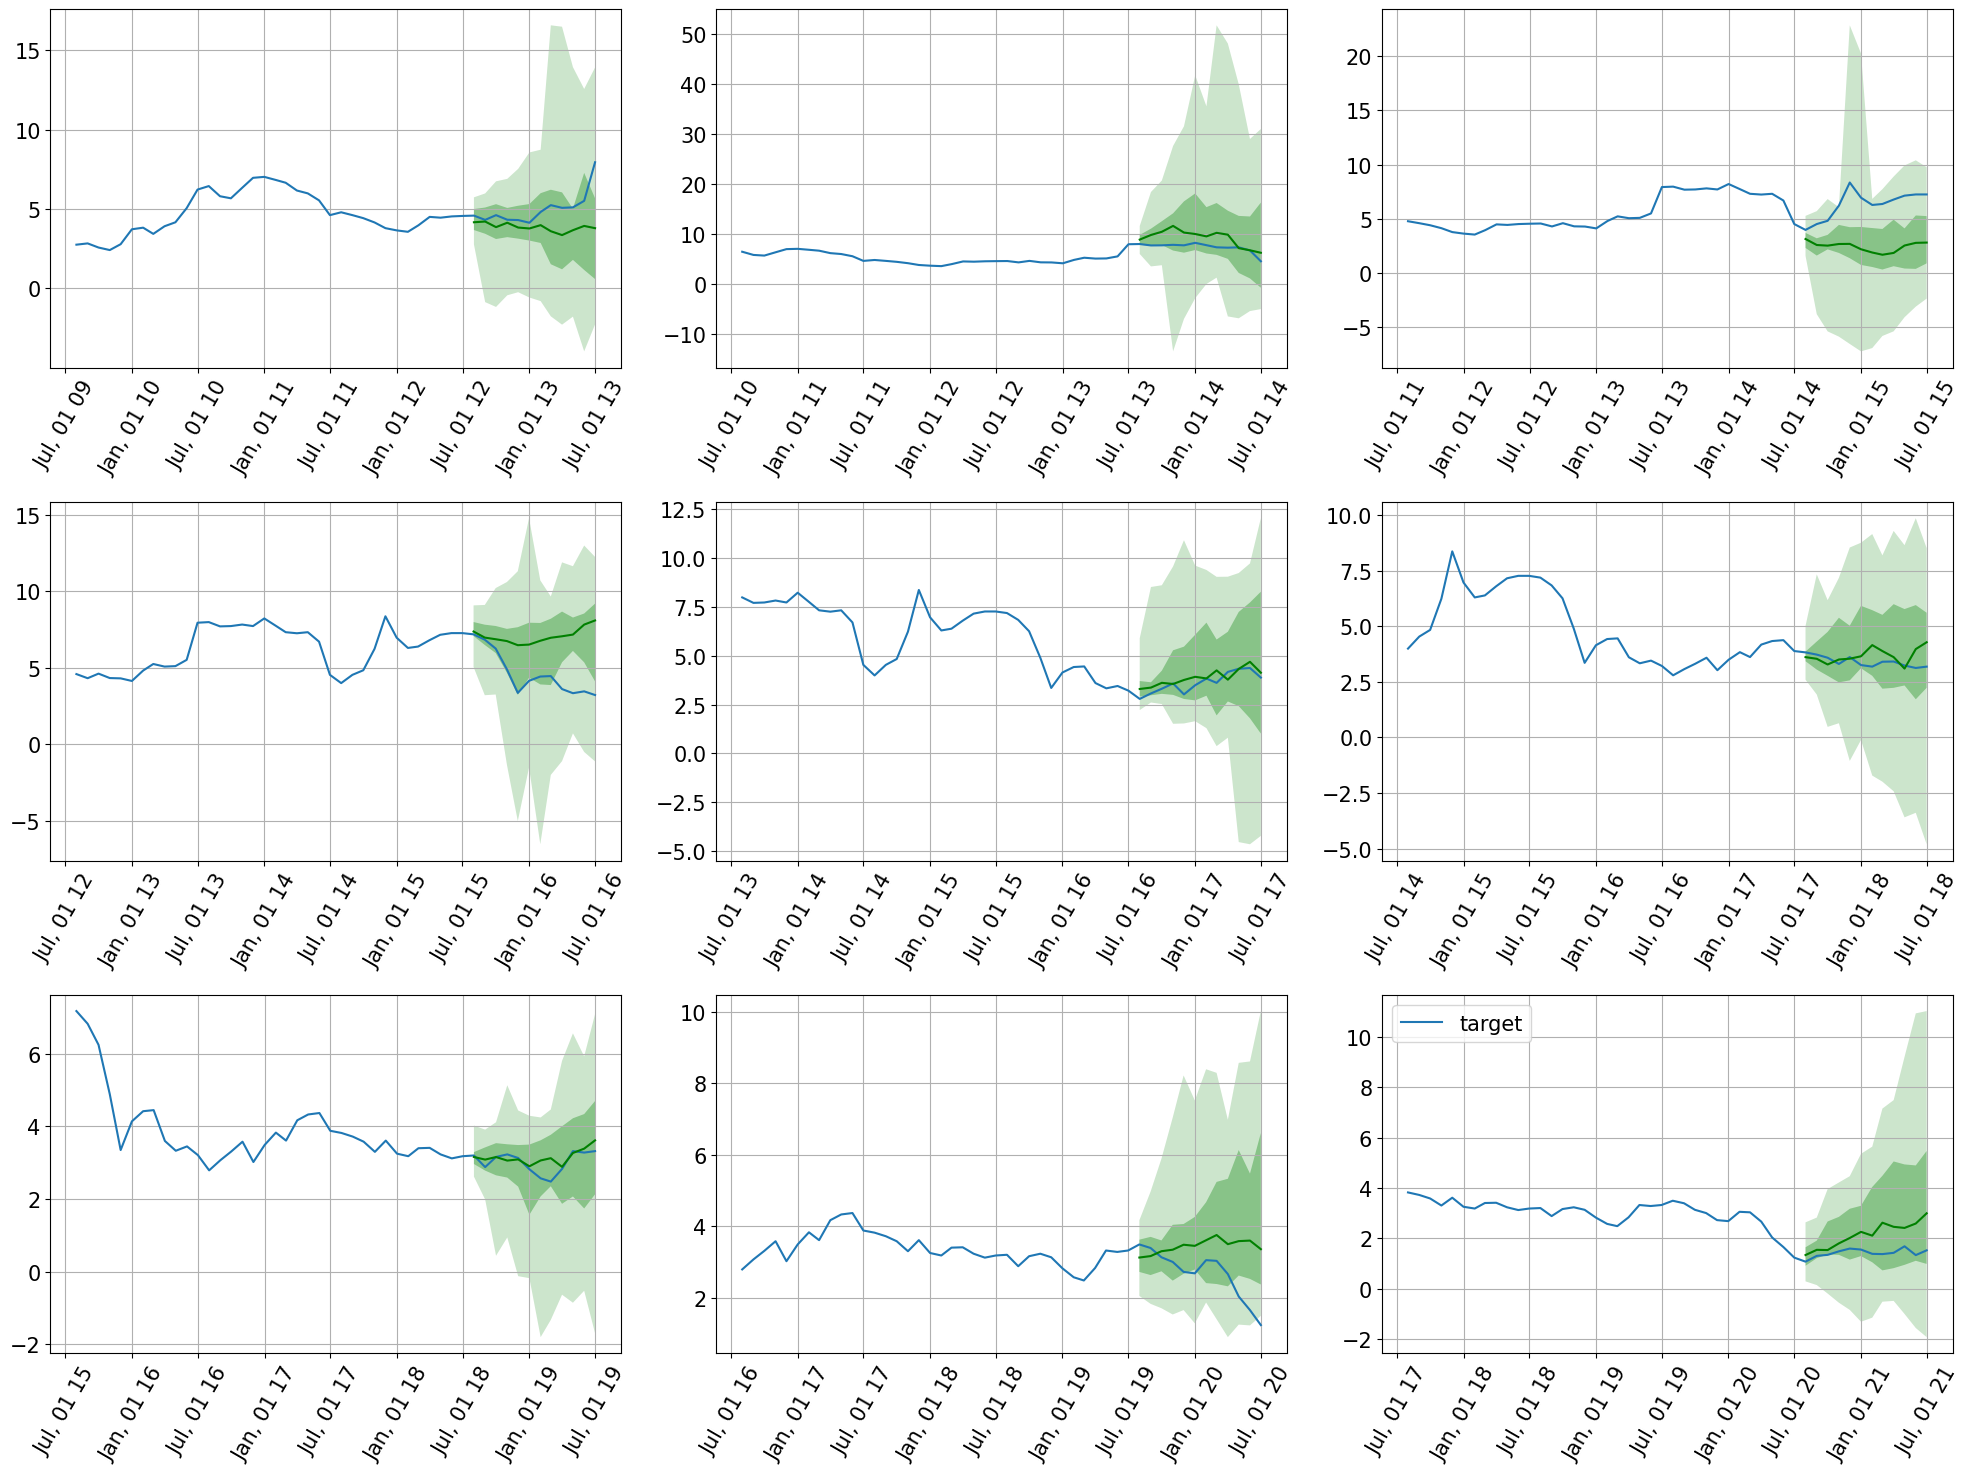

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64, tss_ctx_len_64)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [33]:
#Context Length: 128
forecasts_ctx_len_128, tss_ctx_len_128 = get_lag_llama_predictions(backtest_dataset, prediction_length=12, device=device, \
                                           context_length=128, use_rope_scaling=True, num_samples=30)
forecasts_ctx_len_128 = list(forecasts_ctx_len_128)
tss_ctx_len_128 = list(tss_ctx_len_128)

agg_metrics_ctx_len_128, ts_metrics_ctx_len_128 = evaluator(iter(tss_ctx_len_128), iter(forecasts_ctx_len_128))
print("CRPS:", agg_metrics_ctx_len_128['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_128['MSE'])
print('MAPE:', agg_metrics_ctx_len_128['MAPE'])

/tmp/ipykernel_201029/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.2969555538296348
MSE: 5.70055666475585
MAPE: 0.3361547489960988


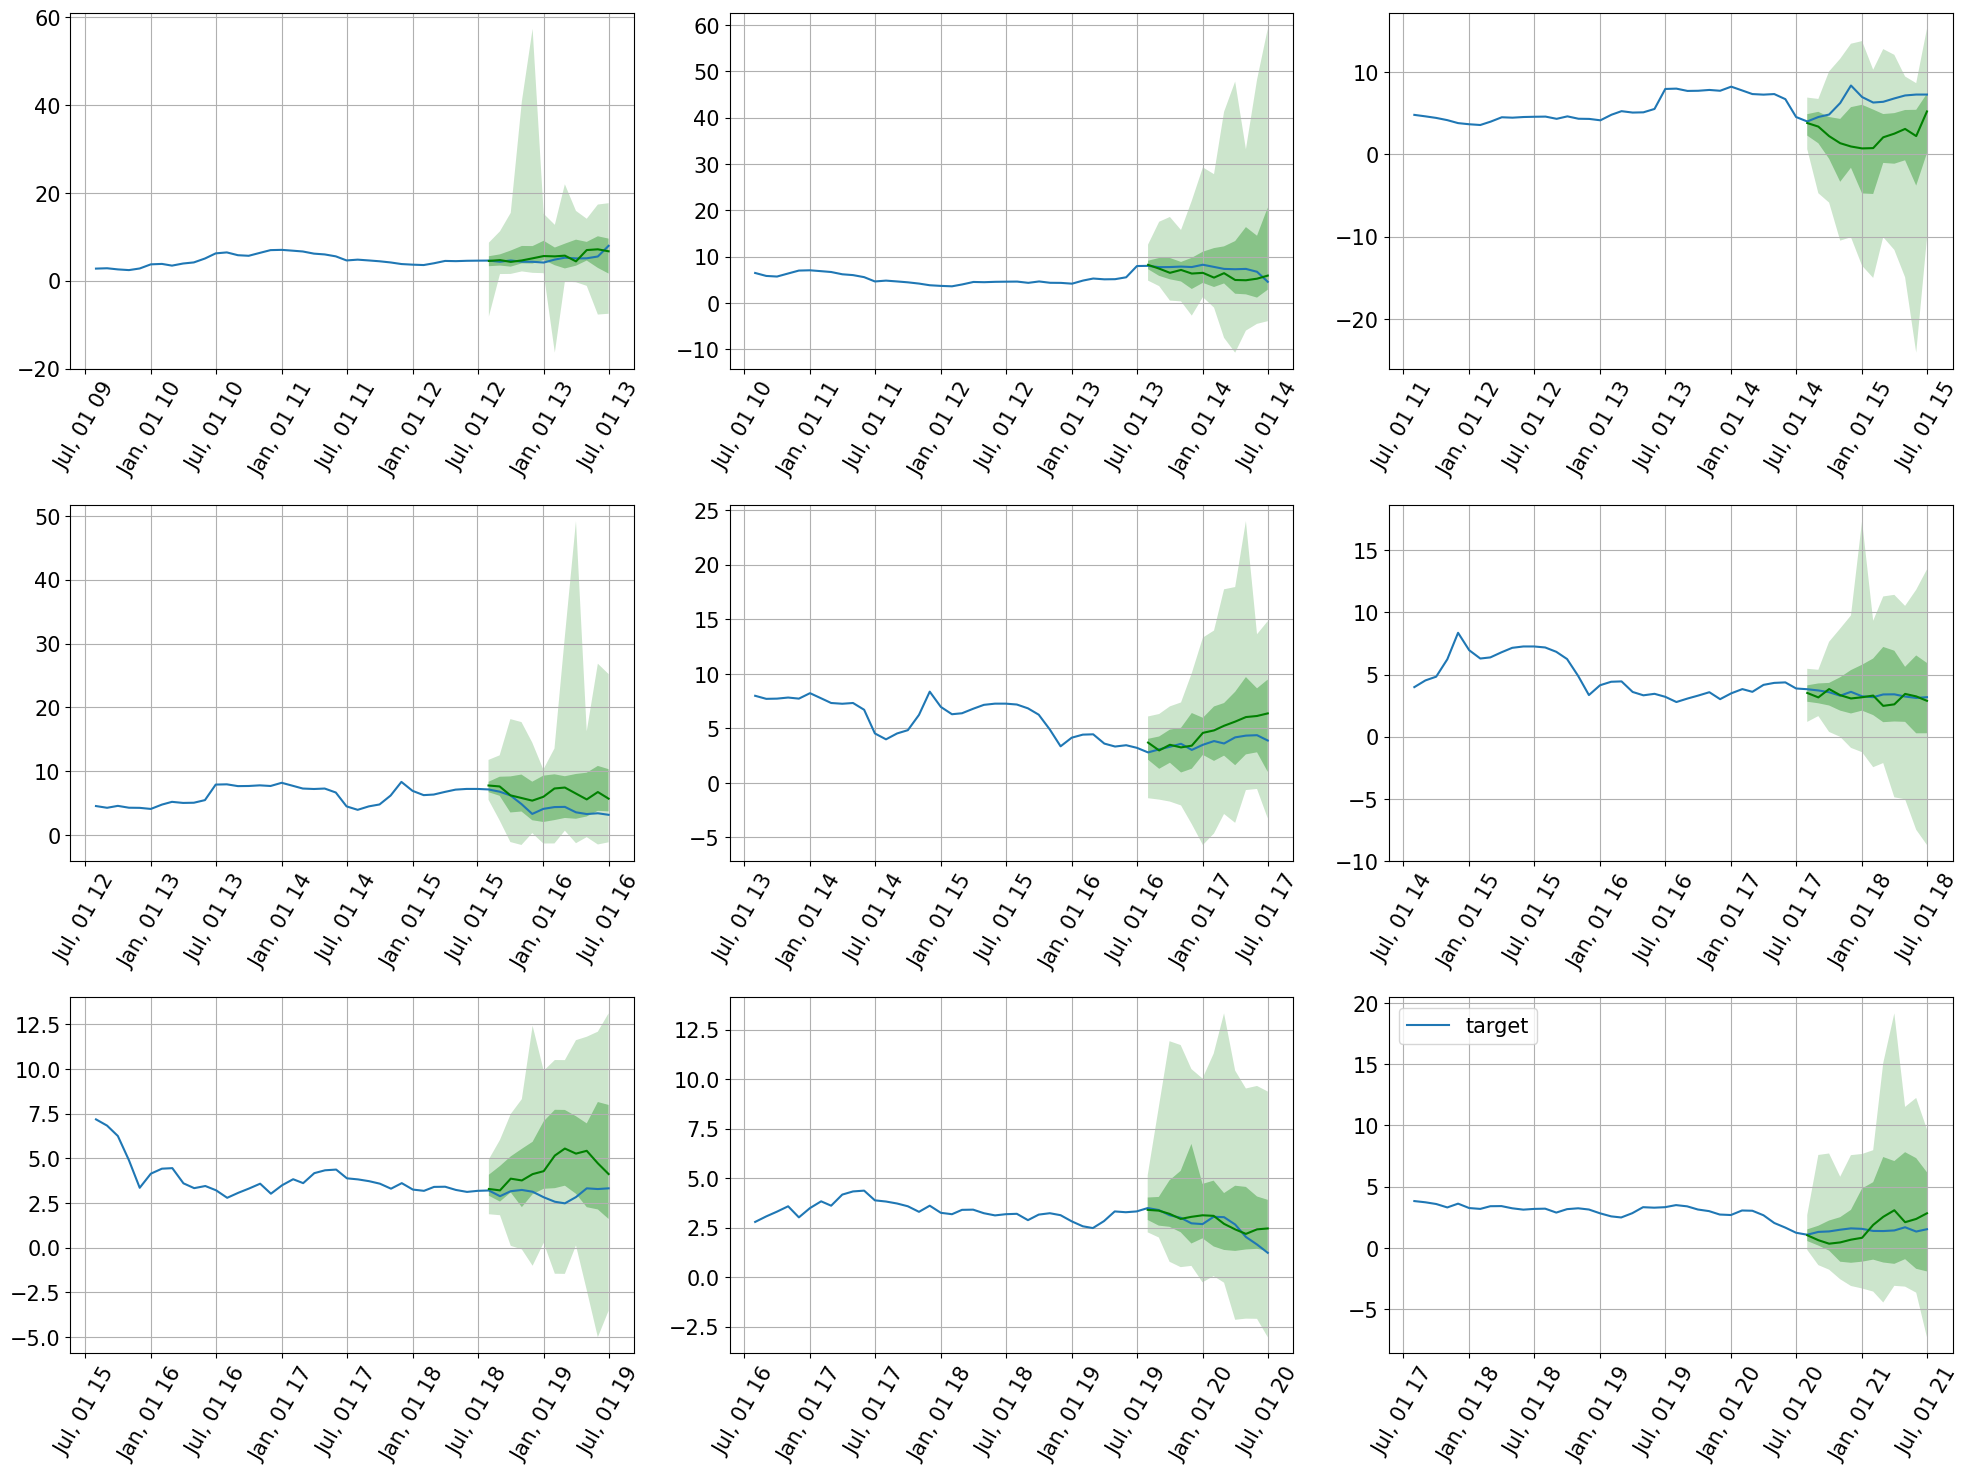

In [34]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_128, tss_ctx_len_128)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()